In [1]:
from music21 import stream, interval, corpus, converter, instrument, metadata
from music21 import note, chord, environment, duration, clef, pitch, key, scale, configure, common
from music21.stream import Score
from music21.stream import Part
from music21.stream import Measure
import notebook
from datetime import date, timedelta
import random, math
import pandas as pd
import pathlib, random, copy
from datetime import date
from builtins import isinstance
import numpy as np
import seaborn as sns
from dwbzen.music import MusicUtils, Instruments

C:\Compile\dwbzen\C:\Program Files\MuseScore 3\bin\MuseScore3.exe


In [2]:
us = environment.UserSettings()
us.getSettingsPath()

WindowsPath('C:/Users/dwbze/AppData/Roaming/music21-settings.xml')

In [3]:
us['musescoreDirectPNGPath']

WindowsPath('C:/Program Files/MuseScore 4/bin/MuseScore4.exe')

### Testing the music21 API


In [4]:
akey = key.Key('C')
pitches = [akey.pitchFromDegree(x) for x in range(15)]
pitches

[<music21.pitch.Pitch B4>,
 <music21.pitch.Pitch C4>,
 <music21.pitch.Pitch D4>,
 <music21.pitch.Pitch E4>,
 <music21.pitch.Pitch F4>,
 <music21.pitch.Pitch G4>,
 <music21.pitch.Pitch A4>,
 <music21.pitch.Pitch B4>,
 <music21.pitch.Pitch C4>,
 <music21.pitch.Pitch D4>,
 <music21.pitch.Pitch E4>,
 <music21.pitch.Pitch F4>,
 <music21.pitch.Pitch G4>,
 <music21.pitch.Pitch A4>,
 <music21.pitch.Pitch B4>]

In [5]:
p = pitch.Pitch('C#')
sdict = MusicUtils.get_scale_degree(akey, p)
sdict

{'pitch': <music21.pitch.Pitch C#>,
 'pitch_name': 'C#',
 'number': '#1',
 'roman': '#I'}

In [6]:
def get_pitch_from_scaleDegree(akey:scale.ConcreteScale, sd:str, octave=None) -> pitch.Pitch:
    #
    # pitchFromDegree api only handles integer scale degrees
    # so for example, in Key('C'), "-3" is actually an e- (e-flat)
    # and "#4" is an F3
    #
    p = None
    if sd.isdigit():
        p = akey.pitchFromDegree(int(sd))
    elif len(sd) >= 2:
        accidental = sd[0]
        semitones = 1
        if accidental == '-' or accidental == 'b':
            semitones = -1
        degree = int(sd[1:])
        p = akey.pitchFromDegree(degree)
        p = p.transpose(interval.Interval(semitones))
    if octave is not None:
        p.octave = octave
    return p


In [7]:
print(get_pitch_from_scaleDegree(akey, '3'))
print(get_pitch_from_scaleDegree(akey, '-3'))
print(get_pitch_from_scaleDegree(akey, '#3'))
print(get_pitch_from_scaleDegree(akey, 'b5'))
print(get_pitch_from_scaleDegree(akey, '3', octave=5))

E4
E-4
F4
F#4
E5


In [8]:
p = get_pitch_from_scaleDegree(akey, '3', octave=3)
anote = note.Note(p)
print(anote)

<music21.note.Note E>


In [9]:
sBach = corpus.parse('bwv67.4')
score_intervals = MusicUtils.get_score_intervals(sBach)
part_intervals = score_intervals['Soprano']
intervals_df, score_partnames, score_partnumbers = MusicUtils.get_intervals_for_score(sBach, partnames=['Soprano'])
intervals_df.head(10)

,interval,part_number,part_name,note1,note2,name,directedName,niceName,semitones
0,<music21.interval.Interval P1>,1,Soprano,<music21.note.Note F#>,<music21.note.Note F#>,P1,P1,Perfect Unison,0
1,<music21.interval.Interval P1>,1,Soprano,<music21.note.Note F#>,<music21.note.Note F#>,P1,P1,Perfect Unison,0
2,<music21.interval.Interval P5>,1,Soprano,<music21.note.Note F#>,<music21.note.Note C#>,P5,P5,Perfect Fifth,7
3,<music21.interval.Interval M2>,1,Soprano,<music21.note.Note C#>,<music21.note.Note D#>,M2,M2,Major Second,2
4,<music21.interval.Interval m2>,1,Soprano,<music21.note.Note D#>,<music21.note.Note E>,m2,m2,Minor Second,1
5,<music21.interval.Interval m-2>,1,Soprano,<music21.note.Note E>,<music21.note.Note D#>,m2,m-2,Minor Second,-1
6,<music21.interval.Interval M-2>,1,Soprano,<music21.note.Note D#>,<music21.note.Note C#>,M2,M-2,Major Second,-2
7,<music21.interval.Interval M-2>,1,Soprano,<music21.note.Note C#>,<music21.note.Note B>,M2,M-2,Major Second,-2
8,<music21.interval.Interval M2>,1,Soprano,<music21.note.Note B>,<music21.note.Note C#>,M2,M2,Major Second,2
9,<music21.interval.Interval M2>,1,Soprano,<music21.note.Note C#>,<music21.note.Note D#>,M2,M2,Major Second,2


In [10]:
order = 2
iloc = 2
key_intervals = intervals_df.iloc[iloc:iloc+order]
next_interval = intervals_df.iloc[iloc+order]
key_intervals
index_str = MusicUtils.show_intervals(key_intervals,'semitones')
print(f"index_str: '{index_str}'")

index_str: '7,2'


In [11]:
durations_df = MusicUtils.get_durations_from_notes(intervals_df)
durations_df.head()

,note,duration,type,ordinal,dots,fullName,quarterLength,tuplets
0,<music21.note.Note F#>,<music21.duration.Duration 1.0>,quarter,6,0,Quarter,1.0,()
1,<music21.note.Note F#>,<music21.duration.Duration 2.0>,half,5,0,Half,2.0,()
2,<music21.note.Note F#>,<music21.duration.Duration 1.0>,quarter,6,0,Quarter,1.0,()
3,<music21.note.Note C#>,<music21.duration.Duration 2.0>,half,5,0,Half,2.0,()
4,<music21.note.Note D#>,<music21.duration.Duration 1.0>,quarter,6,0,Quarter,1.0,()


In [12]:
MusicUtils.show_durations(durations_df.iloc[1:3])

'2.0,1.0'

In [13]:
n = note.Note("F#4")
n.duration = duration.Duration(1.75)
print(MusicUtils.note_info(n))
print()
print(MusicUtils.duration_info(n.duration))
print(n.classes)
print(n)

F#4, type: quarter, dots: 2, fullName: Double Dotted Quarter, quarterLength: 1.75, tuplets: ()

type: quarter, ordinal: 6, dots: 2, fullName: Double Dotted Quarter,         quarterLength 1.75, quarterLengthNoTuplets 1.75, tuplets: ()
('Note', 'NotRest', 'GeneralNote', 'Music21Object', 'ProtoM21Object', 'object')
<music21.note.Note F#>


In [14]:
n1 = note.Note("C2")
n2 = note.Note("B3")
print("{}  {}".format(n1.nameWithOctave, n1.pitch.ps))
print("{}  {}".format(n2.nameWithOctave, n2.pitch.ps))
pitch.Pitch(62)

C2  36.0
B3  59.0


<music21.pitch.Pitch D4>

In [15]:
n1.pitch.getEnharmonic()

<music21.pitch.Pitch B#1>

In [16]:
terminal_note = note.Note('c#8')
initial_note = note.Rest()
initial_note.duration.quarterLength=0
print(MusicUtils.note_info(terminal_note))
print(MusicUtils.note_info(initial_note))
print(terminal_note.nameWithOctave)

C#8, type: quarter, dots: 0, fullName: Quarter, quarterLength: 1.0, tuplets: ()
name: rest, fullName: Zero Rest, type: zero, dots: 0, quarterLength: 0.0
C#8


In [17]:
terminal_note.fullName

'C-sharp in octave 8 Quarter Note'

In [18]:
# tuplets
dur = duration.Duration(quarterLength=0.333333)
n1 = note.Note("F#4", duration=dur)
n2 = note.Note("G4", quarterLength=0.33333)
n3 = note.Note("C5", quarterLength=0.75)
print(MusicUtils.note_info(n1))
print(MusicUtils.note_info(n3))

F#4, type: eighth, dots: 0, fullName: Eighth Triplet (1/3 QL), quarterLength: 1/3, tuplets: (<music21.duration.Tuplet 3/2/eighth>,)
C5, type: eighth, dots: 1, fullName: Dotted Eighth, quarterLength: 0.75, tuplets: ()


In [19]:
p = n.pitch
#dir(p)
p.pitchClass

6

In [20]:
n.show('text')

<music21.note.Note F#>


In [21]:
n.pitch.pitchClass # C=0, C#=1, D=2, D#=3   etc.

6

In [22]:
c = chord.Chord("C4 E4 G#4")
c.isConsonant()

False

### Corpus

In [21]:
corpus.manager.listLocalCorporaNames()

[None, 'ZenAlien2013']

In [23]:
#
# only need to do this once
#
localCorpus = corpus.corpora.LocalCorpus('ZenAlien2013')
localCorpus.addPath("/data/music/Corpus/dwbzen")
localCorpus.addPath("/data/music/Corpus/bach")
localCorpus.save()

C:\python\dwbzen10\lib\site-packages\music21\corpus\corpora.py: WARNING: ZenAlien2013 metadata cache: starting processing of paths: 410
C:\python\dwbzen10\lib\site-packages\music21\corpus\corpora.py: WARNING: cache: filename: C:\Users\dwbze\AppData\Local\Temp\music21\local-ZenAlien2013.p.gz
metadata.bundles: WARNING: MetadataBundle Modification Time: 1699469432.534364
metadata.bundles: WARNING: Skipped 410 sources already in cache.
C:\python\dwbzen10\lib\site-packages\music21\corpus\corpora.py: WARNING: cache: writing time: 1.457 md items: 410

C:\python\dwbzen10\lib\site-packages\music21\corpus\corpora.py: WARNING: cache: filename: C:\Users\dwbze\AppData\Local\Temp\music21\local-ZenAlien2013.p.gz


In [24]:
#env = environment.UserSettings()
#env.keys()
print(localCorpus.directoryPaths)

(WindowsPath('/data/music/Corpus/bach'), WindowsPath('/data/music/Corpus/dwbzen'))


In [25]:
corpus.manager.listLocalCorporaNames()


[None, 'ZenAlien2013']

In [26]:
paths = corpus.getLocalPaths()
paths

[]

### Bach chorale BWV 67.4

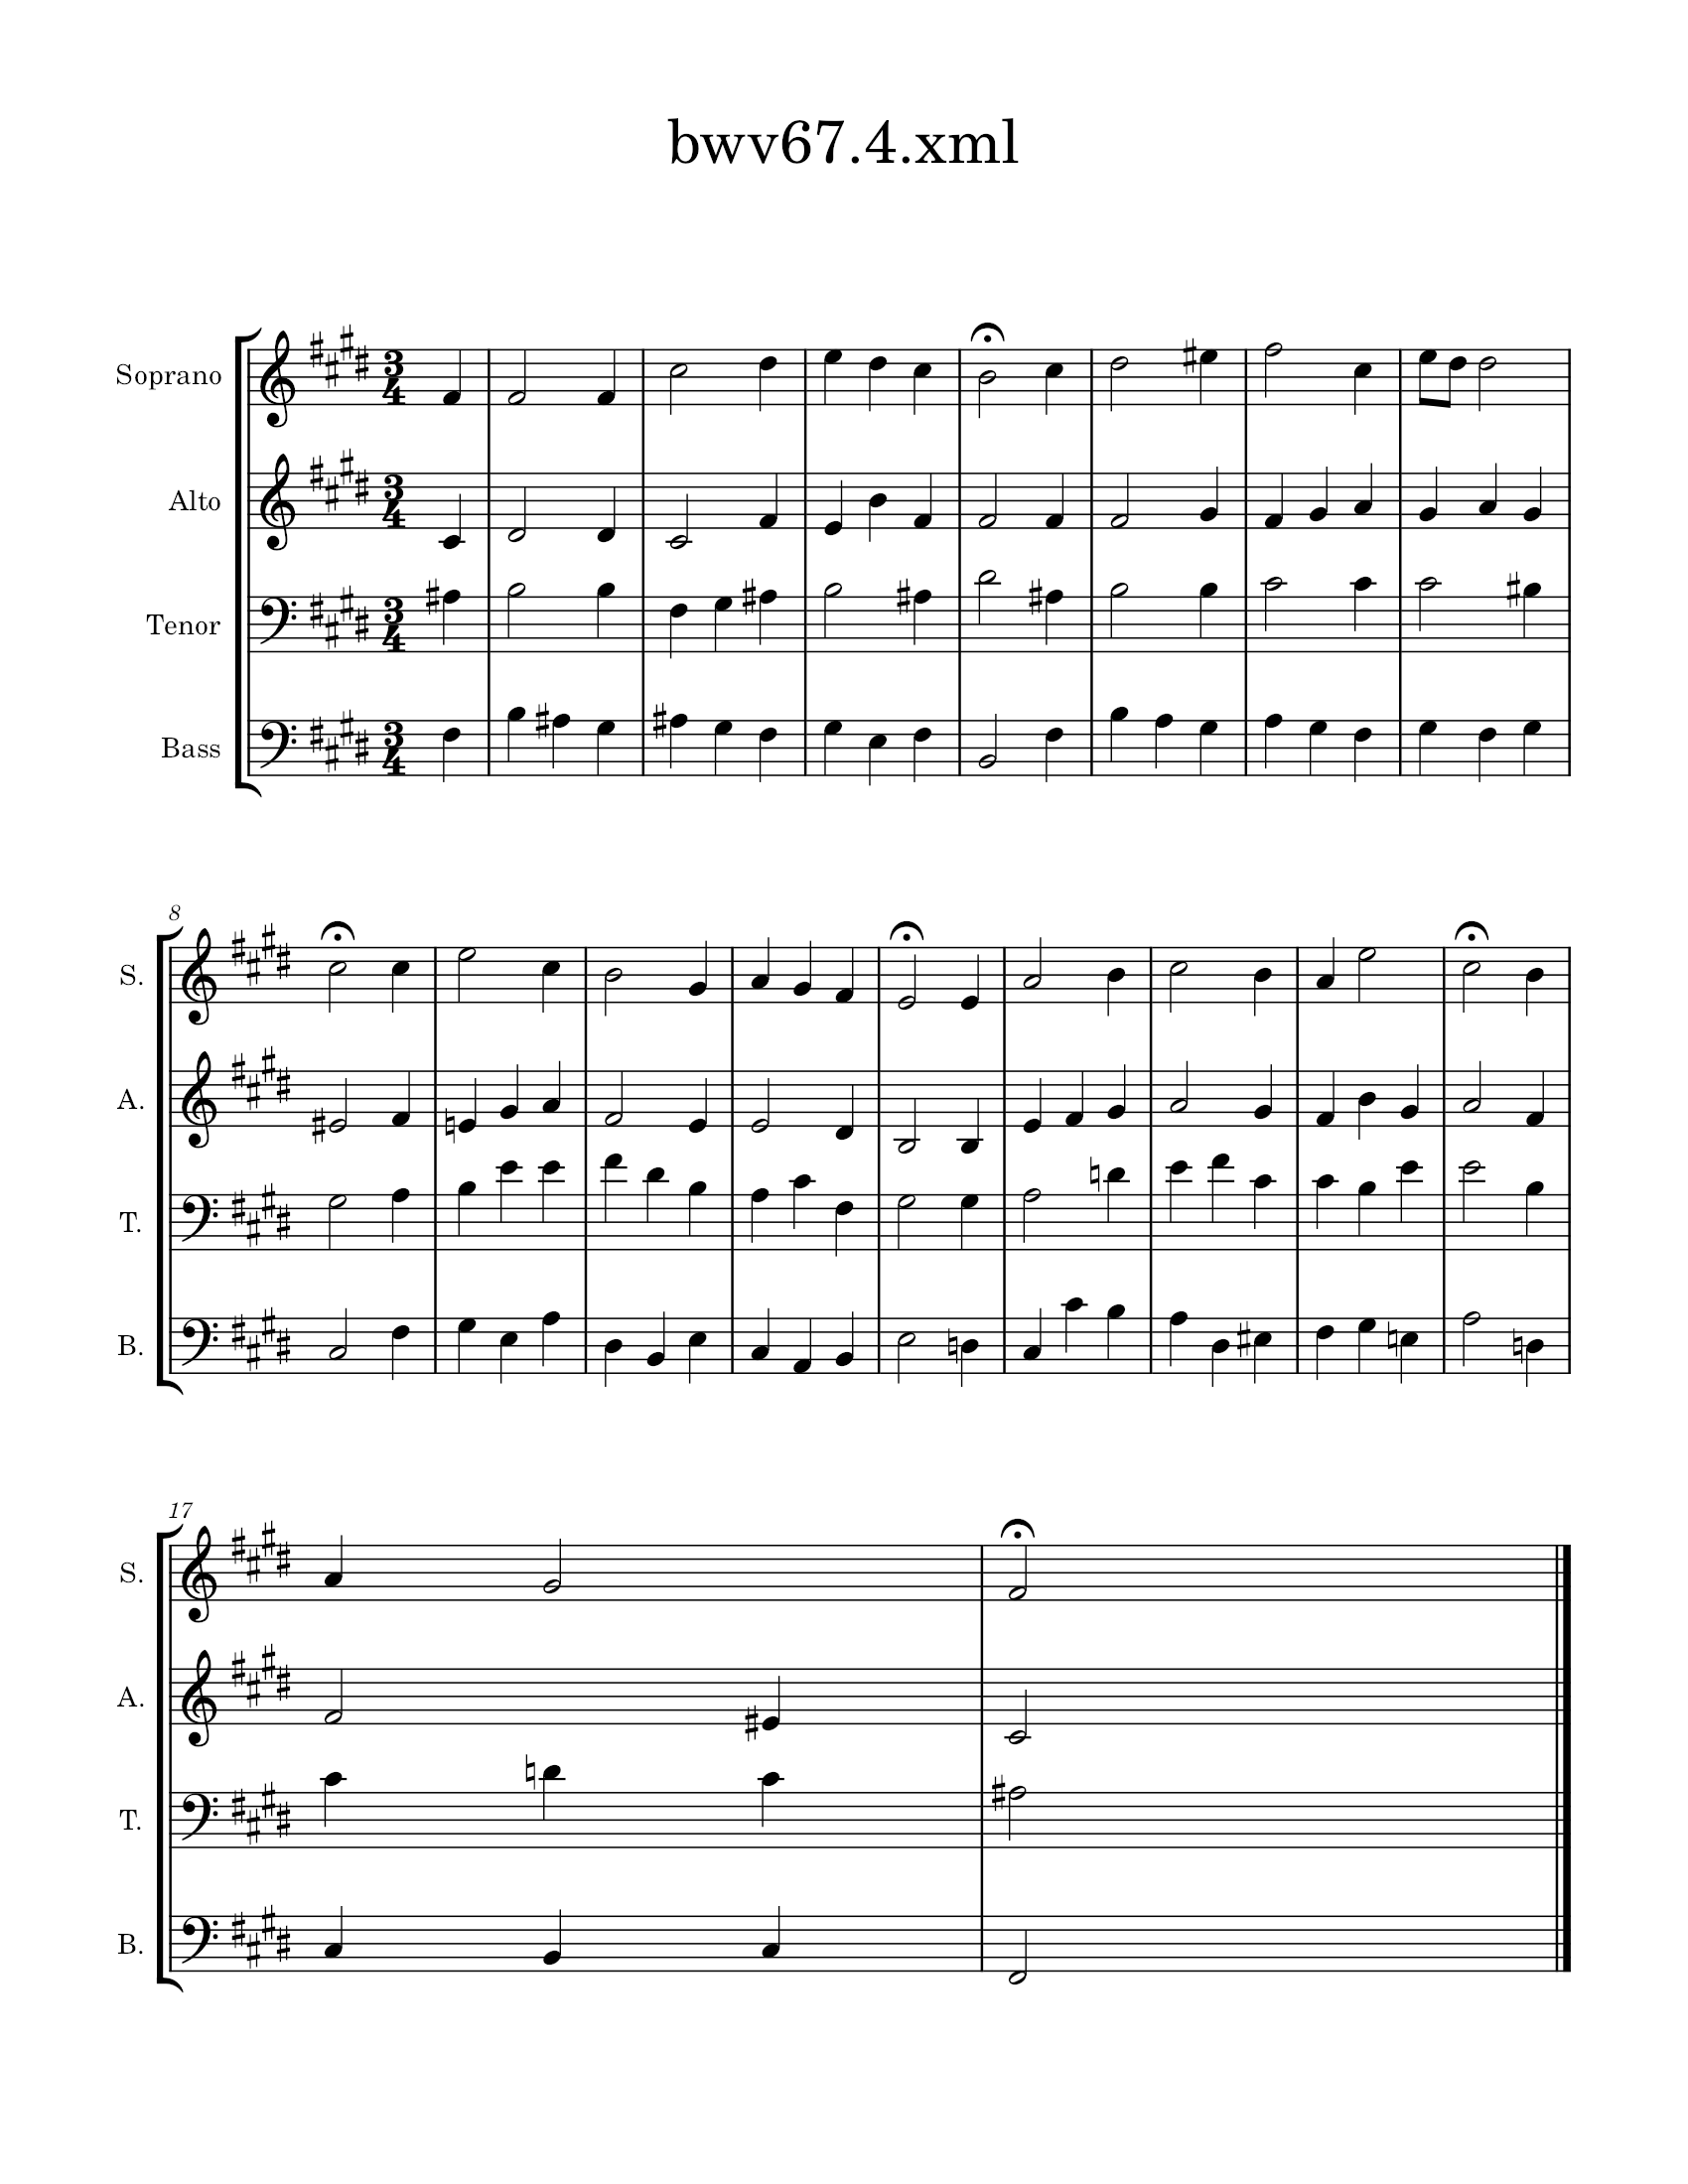

In [27]:
sBach = corpus.parse('bwv67.4')
sBach.show()

In [28]:
pdict = MusicUtils.get_score_intervals(sBach)
list(pdict.keys())

['Soprano', 'Alto', 'Tenor', 'Bass']

In [28]:
part_names = ['Soprano', 'Alto', 'Tenor', 'Bass']
notes_df,pnames,pnums = MusicUtils.get_music21_objects_for_score(note.Note, sBach, part_names)
key_notes = notes_df.iloc[2:4]
key_notes

AttributeError: 'StreamIterator' object has no attribute 'dtype'

In [17]:
MusicUtils.show_notes(key_notes)

'F#,C#'

In [18]:
MusicUtils.show_intervals(key_notes)


'F#,C#'

In [19]:
intervals_df,pnames,pnums = MusicUtils.get_intervals_for_score(sBach, part_names)
notes_df,pnames,pnums = MusicUtils.get_notes_for_score(sBach, part_names)
intervals_df.head()

,interval,part_number,part_name,note1,note2,name,directedName,niceName,semitones
0,<music21.interval.Interval P1>,1,Soprano,<music21.note.Note F#>,<music21.note.Note F#>,P1,P1,Perfect Unison,0
1,<music21.interval.Interval P1>,1,Soprano,<music21.note.Note F#>,<music21.note.Note F#>,P1,P1,Perfect Unison,0
2,<music21.interval.Interval P5>,1,Soprano,<music21.note.Note F#>,<music21.note.Note C#>,P5,P5,Perfect Fifth,7
3,<music21.interval.Interval M2>,1,Soprano,<music21.note.Note C#>,<music21.note.Note D#>,M2,M2,Major Second,2
4,<music21.interval.Interval m2>,1,Soprano,<music21.note.Note D#>,<music21.note.Note E>,m2,m2,Minor Second,1


In [20]:
notes_df.head()

,note,part_number,part_name,name,nameWithOctave,pitch,duration,pitchClass
0,<music21.note.Note F#>,1,Soprano,F#,F#4,F#4,<music21.duration.Duration 1.0>,6
1,<music21.note.Note F#>,1,Soprano,F#,F#4,F#4,<music21.duration.Duration 2.0>,6
2,<music21.note.Note F#>,1,Soprano,F#,F#4,F#4,<music21.duration.Duration 1.0>,6
3,<music21.note.Note C#>,1,Soprano,C#,C#5,C#5,<music21.duration.Duration 2.0>,1
4,<music21.note.Note D#>,1,Soprano,D#,D#5,D#5,<music21.duration.Duration 1.0>,3


In [63]:
print("part_names: {},  \npart_numbers: {}".format(pnames,pnums))

part_names: {'Alto', 'Soprano', 'Bass', 'Tenor'},  
part_numbers: {1, 2, 3, 4}


In [64]:
print('len: {}  number of parts: {}'.format(len(sBach), len(sBach.parts)))
for sb in sBach.parts:
    print(sb, len(sb))

len: 6  number of parts: 4
<music21.stream.Part Soprano> 20
<music21.stream.Part Alto> 20
<music21.stream.Part Tenor> 20
<music21.stream.Part Bass> 20


In [70]:
soprano = sBach.parts[0]
alto = sBach.parts[1]
tenor = sBach.parts[2]
bass = sBach.parts[3]
soprano_measures = soprano.getElementsByClass('Measure')
print(len(soprano_measures))
i = 1
lim = 3
for measure in soprano_measures:
    notes = measure.getElementsByClass(['Note','Chord','Rest'])
    print('measure {}'.format(i))
    for n in notes:
        if n.isNote:
            print(n.nameWithOctave)
        else:
            print(n.fullName)
    #print(n.instrument)
    i = i+1
    if i > lim:
        break
    measure.show('text')

19
measure 1
F#4
{0.0} <music21.clef.TrebleClef>
{0.0} <music21.key.Key of E major>
{0.0} <music21.meter.TimeSignature 3/4>
{0.0} <music21.note.Note F#>
measure 2
F#4
F#4
{0.0} <music21.note.Note F#>
{2.0} <music21.note.Note F#>
measure 3
C#5
D#5


In [71]:
soprano.partName

'Soprano'

In [164]:
bs = soprano.flatten().transpose(-3)
[str(p) for p in bs.pitches[:20]]

['E-4',
 'E-4',
 'E-4',
 'B-4',
 'C5',
 'D-5',
 'C5',
 'B-4',
 'A-4',
 'B-4',
 'C5',
 'D5',
 'E-5',
 'B-4',
 'D-5',
 'C5',
 'C5',
 'B-4',
 'B-4',
 'D-5']

In [152]:
bwv410 = corpus.parse('bwv410')
part0 = bwv410.parts[0]
[str(p) for p in part0.flat.pitches[:15]]

['G4',
 'A4',
 'B-4',
 'B-4',
 'C5',
 'B-4',
 'A4',
 'A4',
 'B-4',
 'C5',
 'D5',
 'D5',
 'E-5',
 'D5',
 'C5']

In [160]:
bs = part0.flatten().transpose(2)
[str(p) for p in bs.pitches[:20]]

['A4',
 'B4',
 'C5',
 'C5',
 'D5',
 'C5',
 'B4',
 'B4',
 'C5',
 'D5',
 'E5',
 'E5',
 'F5',
 'E5',
 'D5',
 'D5',
 'C5',
 'E5',
 'D5',
 'E5']

In [75]:
# or all the Notes in a Part along with the durations
soprano_notes = soprano.flat.getElementsByClass('Note')
print(f'Number of notes in Soprano part: {len(soprano_notes)} ' )
i = 0
lim = 5
for x in soprano_notes:
    print('{} {}'.format(x.nameWithOctave,x.duration.type))
    i = i + 1
    if i> lim:
        break

Number of notes in Soprano part: 39 
F#4 quarter
F#4 half
F#4 quarter
C#5 half
D#5 quarter
E5 quarter


In [76]:
# or all the Notes in the tenor Part along with the durations
tenor_notes = tenor.flat.getElementsByClass('Note')
print(f'Number of notes in Tenor part: {len(tenor_notes)} ' )
for x in tenor_notes:
    # print('{} {}'.format(x.nameWithOctave,x.duration.type))
    pass

Number of notes in Tenor part: 43 


## [Intervals](https://web.mit.edu/music21/doc/usersGuide/usersGuide_18_intervals.html)

In [77]:
# get the intervals in the tenor part
for ind in range(10):   # range(len(tenor_notes)-1):
    n1 = tenor_notes[ind]
    n2 = tenor_notes[ind+1]
    i = interval.Interval(n1, n2)
    print('{}\t{}\tsteps: {}\t{}\t{}\t{}'.format(n1.nameWithOctave, n2.nameWithOctave, i.semitones, 
                                             i.name, i.directedName, i.niceName))
    

A#3	B3	steps: 1	m2	m2	Minor Second
B3	B3	steps: 0	P1	P1	Perfect Unison
B3	F#3	steps: -5	P4	P-4	Perfect Fourth
F#3	G#3	steps: 2	M2	M2	Major Second
G#3	A#3	steps: 2	M2	M2	Major Second
A#3	B3	steps: 1	m2	m2	Minor Second
B3	A#3	steps: -1	m2	m-2	Minor Second
A#3	D#4	steps: 5	P4	P4	Perfect Fourth
D#4	A#3	steps: -5	P4	P-4	Perfect Fourth
A#3	B3	steps: 1	m2	m2	Minor Second


In [78]:
corpus.search('bach','composer')

<music21.metadata.bundles.MetadataBundle {363 entries}>

In [79]:
sBach = corpus.parse('bwv29.8')
intervals_df,pname,pnums = MusicUtils.get_intervals_for_score(sBach)

In [81]:
intervals_df[['name','directedName','niceName','semitones','part_name','part_number']]

,name,directedName,niceName,semitones,part_name,part_number
0,P5,P-5,Perfect Fifth,-7,Trumpet 1,1
1,P4,P4,Perfect Fourth,5,Trumpet 1,1
2,m2,m-2,Minor Second,-1,Trumpet 1,1
3,M2,M-2,Major Second,-2,Trumpet 1,1
4,m3,m3,Minor Third,3,Trumpet 1,1
...,...,...,...,...,...,...
10,P4,P-4,Perfect Fourth,-5,Timpani,8
11,P1,P1,Perfect Unison,0,Timpani,8
12,P4,P4,Perfect Fourth,5,Timpani,8
13,P4,P-4,Perfect Fourth,-5,Timpani,8


In [82]:
int_df = intervals_df.groupby(by=['semitones']).count()[['interval']]
int_df.rename(columns={'interval':'count'}, inplace=True)
int_df.reset_index(inplace=True)

In [83]:
int_df.sort_values(by='count', ascending=False)

,semitones,count
6,-2,127
10,2,77
8,0,76
7,-1,63
13,5,42
9,1,41
1,-7,16
3,-5,13
5,-3,10
4,-4,9


In [21]:
import re
mytitle = '^bwv4+'
titles_re = re.compile(mytitle, re.IGNORECASE)
# mobj = titles_re.match('bwv102.7.mxl')
meta = corpus.search(titles_re, field='title')
titles = [meta[i].metadata.title for i in range(len(meta))]
print(titles)

['bwv4.8.mxl', 'bwv40.3.mxl', 'bwv40.6.mxl', 'bwv40.8.mxl', 'bwv400.mxl', 'bwv401.mxl', 'bwv402.mxl', 'bwv403.mxl', 'bwv404.mxl', 'bwv405.mxl', 'bwv406.mxl', 'bwv407.mxl', 'bwv408.mxl', 'bwv409.mxl', 'bwv41.6.mxl', 'bwv410.mxl', 'bwv411.mxl', 'bwv412.mxl', 'bwv413.mxl', 'bwv414.mxl', 'bwv415.mxl', 'bwv416.mxl', 'bwv417.mxl', 'bwv418.mxl', 'bwv419.mxl', 'bwv42.7.mxl', 'bwv420.mxl', 'bwv421.mxl', 'bwv422.mxl', 'bwv423.mxl', 'bwv424.mxl', 'bwv425.mxl', 'bwv426.mxl', 'bwv427.mxl', 'bwv428.mxl', 'bwv429.mxl', 'bwv43.11.mxl', 'bwv430.mxl', 'bwv431.mxl', 'bwv432.mxl', 'bwv433.mxl', 'bwv434.mxl', 'bwv435.mxl', 'bwv436.mxl', 'bwv437.mxl', 'bwv438.mxl', 'bwv44.7.mxl', 'bwv45.7.mxl', 'bwv46.6.mxl', 'bwv47.5.mxl', 'bwv48.3.mxl', 'bwv48.7.mxl']


In [22]:
meta = MusicUtils.get_metadata_bundle(composer='Bach', title='^bwv1+')
titles = [meta[i].metadata.title for i in range(len(meta))]
print(titles)

['bwv10.7.mxl', 'bwv101.7.mxl', 'bwv102.7.mxl', 'bwv103.6.mxl', 'bwv104.6.mxl', 'bwv108.6.mxl', 'bwv11.6.mxl', 'bwv110.7.mxl', 'bwv112.5-sc.mxl', 'bwv113.8.mxl', 'bwv114.7.mxl', 'bwv115.6.mxl', 'bwv117.4.mxl', 'bwv121.6.mxl', 'bwv122.6.mxl', 'bwv123.6.mxl', 'bwv126.6.mxl', 'bwv127.5.mxl', 'bwv13.6.mxl', 'bwv133.6.mxl', 'bwv136.6.mxl', 'bwv14.5.mxl', 'bwv140.7.mxl', 'bwv144.3.mxl', 'bwv144.6.mxl', 'bwv145.5.mxl', 'bwv148.6.mxl', 'bwv151.5.mxl', 'bwv153.1.mxl', 'bwv153.5.mxl', 'bwv153.9.mxl', 'bwv154.3.mxl', 'bwv154.8.mxl', 'bwv155.5.mxl', 'bwv156.6.mxl', 'bwv159.5.mxl', 'bwv16.6.mxl', 'bwv161.6.mxl', 'bwv164.6.mxl', 'bwv166.6.mxl', 'bwv168.6.mxl', 'bwv169.7.mxl', 'bwv17.7.mxl', 'bwv172.6.mxl', 'bwv174.5.mxl', 'bwv176.6.mxl', 'bwv177.4.mxl', 'bwv177.5.mxl', 'bwv179.6.mxl', 'bwv18.5-lz.mxl', 'bwv18.5-w.mxl', 'bwv180.7.mxl', 'bwv183.5.mxl', 'bwv184.5.mxl', 'bwv187.7.mxl', 'bwv19.7.mxl', 'bwv194.12.mxl', 'bwv194.6.mxl', 'bwv197.10.mxl', 'bwv197.5.mxl']


In [23]:
df, pnames,pnums = MusicUtils.get_all_score_intervals(composer='Bach',title='^bwv1+') # ,partnames=['Tenor'])
print(df.head())
print(pnames)
print(pnums)

                          interval  part_number part_name  \
0   <music21.interval.Interval m3>            1   Soprano   
1  <music21.interval.Interval m-3>            1   Soprano   
2   <music21.interval.Interval P1>            1   Soprano   
3   <music21.interval.Interval P1>            1   Soprano   
4   <music21.interval.Interval P1>            1   Soprano   

                   note1                  note2 name directedName  \
0  <music21.note.Note D>  <music21.note.Note F>   m3           m3   
1  <music21.note.Note F>  <music21.note.Note D>   m3          m-3   
2  <music21.note.Note D>  <music21.note.Note D>   P1           P1   
3  <music21.note.Note D>  <music21.note.Note D>   P1           P1   
4  <music21.note.Note D>  <music21.note.Note D>   P1           P1   

         niceName  semitones        title  
0     Minor Third          3  bwv10.7.mxl  
1     Minor Third         -3  bwv10.7.mxl  
2  Perfect Unison          0  bwv10.7.mxl  
3  Perfect Unison          0  bwv10.7.mxl 

In [24]:
df_notes, pnames,pnums = MusicUtils.get_all_score_notes(composer='Bach',title='^bwv1+') # ,partnames=['Tenor'])
print(df_notes.head())
print(pnames)
print(pnums)

                    note  part_number part_name name nameWithOctave pitch  \
0  <music21.note.Note D>            1   Soprano    D             D5    D5   
1  <music21.note.Note F>            1   Soprano    F             F5    F5   
2  <music21.note.Note D>            1   Soprano    D             D5    D5   
3  <music21.note.Note D>            1   Soprano    D             D5    D5   
4  <music21.note.Note D>            1   Soprano    D             D5    D5   

                          duration  pitchClass        title  
0  <music21.duration.Duration 2.0>           2  bwv10.7.mxl  
1  <music21.duration.Duration 2.0>           5  bwv10.7.mxl  
2  <music21.duration.Duration 1.0>           2  bwv10.7.mxl  
3  <music21.duration.Duration 1.0>           2  bwv10.7.mxl  
4  <music21.duration.Duration 1.0>           2  bwv10.7.mxl  
{'Tenor', 'Horn 2', 'Recorders', 'Horn 3', 'Horn 1', 'Cornet 2', 'Bass', 'Alto', 'Oboe', 'Soprano', 'Violin', 'Cornet 1', 'Timpani'}
{1, 2, 3, 4, 5, 6, 7, 8}


In [3]:
md = MusicUtils.get_metadata_bundle('bach','bwv31*')
len(md)

107

In [17]:
idf = df.iloc[2:4]
idf['name'].values.tolist()

['m3', 'M2']

In [20]:
print(MusicUtils.show_intervals(idf,'name'))
intervals = MusicUtils.show_intervals(idf,'semitones')
print(intervals)
# print(show_intervals([df.iloc[2:4]],'directedName'))
#print(df.iloc[2:4]['name'].values.tolist())
#print(df.iloc[2:4]['semitones'].values.tolist())
#intervals = df.iloc[2:4]
#str(intervals['semitones'].values.tolist())
intervals.replace(' ','')

['m3', 'M2']
[-3, 2]


'[-3,2]'

In [65]:
interval = df.iloc[3]
print(f"{df.iloc[2]['name']}")
print(f"{df.iloc[2]['semitones']}")

P1
0


In [25]:
int_df = df.groupby(by=['semitones']).count()[['interval']]
int_df.rename(columns={'interval':'count'}, inplace=True)
int_df.reset_index(inplace=True)

In [26]:
int_df.sort_values(by='count', ascending=False)

,semitones,count
11,-2,2933
15,2,2638
13,0,1998
12,-1,1856
14,1,1670
18,5,714
6,-7,368
9,-4,341
10,-3,303
8,-5,299


In [66]:
n1 = note.Note('A0')
n2 = note.Note('C8')
aInterval = interval.Interval(n1,n2)
print(aInterval.name)
print(aInterval.directedName)
print(aInterval.semitones)

m52
m52
87


In [3]:
terminal_object = interval.Interval(100)
initial_object = interval.Interval(99)
initial_dict = {'interval':initial_object, 'name':initial_object.name, 'directedName':initial_object.directedName,\
                        'niceName':initial_object.niceName, 'semitones':initial_object.semitones, 'part_number':1, 'part_name':'rest'}
initial_object_df = pd.DataFrame(data=initial_dict, index=[0]) 

In [7]:
initial_object.semitones

99

## [Notes](https://web.mit.edu/music21/doc/moduleReference/moduleNote.html)


In [28]:
sBach = corpus.parse('bwv67.4')
sBach

<music21.stream.Score 0x2af61fbe970>

In [8]:
notes_df,pnames,pnums = MusicUtils.get_notes_for_score(sBach)
print("part_names: {},  \npart_numbers: {}".format(pnames,pnums))

part_names: {'Alto', 'Soprano', 'Tenor', 'Bass'},  
part_numbers: {1, 2, 3, 4}


In [9]:
terminal_object = note.Rest()
terminal_object.duration.quarterLength=24
initial_object = note.Rest()
initial_object.duration.quarterLength=0
partNotes_df = notes_df[notes_df['part_name']=='Soprano']
partNotes_df.head()

,note,part_number,part_name,name,nameWithOctave,pitch,duration,pitchClass
0,<music21.note.Note F#>,1,Soprano,F#,F#4,F#4,<music21.duration.Duration 1.0>,6
1,<music21.note.Note F#>,1,Soprano,F#,F#4,F#4,<music21.duration.Duration 2.0>,6
2,<music21.note.Note F#>,1,Soprano,F#,F#4,F#4,<music21.duration.Duration 1.0>,6
3,<music21.note.Note C#>,1,Soprano,C#,C#5,C#5,<music21.duration.Duration 2.0>,1
4,<music21.note.Note D#>,1,Soprano,D#,D#5,D#5,<music21.duration.Duration 1.0>,3


In [21]:
initial_object.name

'rest'

In [10]:
initial_dict = {'note':initial_object, 'part_number':1, 'part_name':'rest', 
               'nameWithOctave':'rest', 'pitch':'', 'duration':initial_object.duration, 
                'pitchClass':0, 'name':'rest'}
initial_df = pd.DataFrame(data=initial_dict, index=[0])
initial_df.append(partNotes_df[0:1])
initial_df.iloc[0]

note                     <music21.note.Rest zero>
part_number                                     1
part_name                                    rest
nameWithOctave                               rest
pitch                                            
duration          <music21.duration.Duration 0.0>
pitchClass                                      0
name                                         rest
Name: 0, dtype: object

In [11]:
notes_df[['note','duration']]

,note,duration
0,<music21.note.Note F#>,<music21.duration.Duration 1.0>
1,<music21.note.Note F#>,<music21.duration.Duration 2.0>
2,<music21.note.Note F#>,<music21.duration.Duration 1.0>
3,<music21.note.Note C#>,<music21.duration.Duration 2.0>
4,<music21.note.Note D#>,<music21.duration.Duration 1.0>
...,...,...
44,<music21.note.Note D>,<music21.duration.Duration 1.0>
45,<music21.note.Note C#>,<music21.duration.Duration 1.0>
46,<music21.note.Note B>,<music21.duration.Duration 1.0>
47,<music21.note.Note C#>,<music21.duration.Duration 1.0>


In [12]:
durations_df = MusicUtils.get_durations_from_notes(notes_df)
durations_df

,note,duration,type,ordinal,dots,fullName,quarterLength,tuplets
0,<music21.note.Note F#>,<music21.duration.Duration 1.0>,quarter,6,0,Quarter,1.0,()
1,<music21.note.Note F#>,<music21.duration.Duration 2.0>,half,5,0,Half,2.0,()
2,<music21.note.Note F#>,<music21.duration.Duration 1.0>,quarter,6,0,Quarter,1.0,()
3,<music21.note.Note C#>,<music21.duration.Duration 2.0>,half,5,0,Half,2.0,()
4,<music21.note.Note D#>,<music21.duration.Duration 1.0>,quarter,6,0,Quarter,1.0,()
...,...,...,...,...,...,...,...,...
44,<music21.note.Note D>,<music21.duration.Duration 1.0>,quarter,6,0,Quarter,1.0,()
45,<music21.note.Note C#>,<music21.duration.Duration 1.0>,quarter,6,0,Quarter,1.0,()
46,<music21.note.Note B>,<music21.duration.Duration 1.0>,quarter,6,0,Quarter,1.0,()
47,<music21.note.Note C#>,<music21.duration.Duration 1.0>,quarter,6,0,Quarter,1.0,()


In [45]:
# parse a single music xml file
# 
score = converter.parse('/compile/dwbzen/resources/music/Prelude.mxl')
len(score.parts)

2

In [46]:
print('len: {}  number of parts: {}'.format(len(score), len(score.parts)))
for sb in score.parts:
    print(sb, len(sb))

len: 10  number of parts: 2
<music21.stream.PartStaff P1-Staff1> 40
<music21.stream.PartStaff P1-Staff2> 21


In [48]:
intervals_df,pnames,pnums = MusicUtils.get_intervals_for_score(score)
intervals_df
print(pnames)
print(pnums)

{'Piano'}
{1}


In [51]:
stats_df = MusicUtils.get_interval_stats(score)
stats_df

,semitones,count
15,-2,13
20,3,9
10,-7,9
21,4,8
19,2,6
17,0,6
16,-1,6
13,-4,5
24,7,5
14,-3,4


In [163]:
stats_df.apply(np.sum, axis=0)    # sum the columns (along the rows)

semitones      3
count        120
dtype: int64

In [18]:
instrument_path = "/Compile/dwbzen/resources/music/instruments.json"
instruments_pd = pd.read_json(instrument_path, orient='index')
instruments_pd

,module,class,range,pitchRange,clef,transposeDiatonic,transposeChromatic,transposeText
Alto,music21.instrument,Alto,"E3,F5","52,77",Treble,NaN,NaN,NaN
Bass,music21.instrument,Bass,"D2,D4","38,62",Bass,NaN,NaN,NaN
Bassoon,music21.instrument,Bassoon,"C2,Ab4","34,76",Bass,NaN,NaN,NaN
Clarinet,music21.instrument,Clarinet,"E3,C6","52,84",Treble,-1.0,-2.0,Sounds a major 2nd lower than written
English Horn,music21.instrument,EnglishHorn,"Bb3,D6","58,86",Treble,-4.0,-7.0,Sounds a perfect 5th lower than written
Flute,music21.instrument,Flute,"C4,C6","72,84",Treble,NaN,NaN,NaN
Harpsichord,music21.instrument,Harpsichord,"C2,C7","36,96",Treble,NaN,NaN,NaN
Koto,music21.instrument,Koto,"G3,G5","55,79",Treble,NaN,NaN,NaN
Oboe,music21.instrument,Oboe,"D4,A5","62,81",Treble,NaN,NaN,NaN
Piano,music21.instrument,Piano,"A0,C8","21,108",Treble,NaN,NaN,NaN


In [19]:
def __define_pitch_range(row:pd.Series):
    notes = row['range'].split(",")
    nlow = note.Note(notes[0])
    nhigh = note.Note(notes[1])
    rlow = int(nlow.pitch.ps)
    rhigh = int(nhigh.pitch.ps)
    return [rlow,rhigh]

In [20]:
instruments_pd['range_ps'] = [__define_pitch_range(row[1]) for row in instruments_pd.iterrows()]

In [24]:
instruments_pd.fillna(value={'transposeDiatonic':0}, inplace=True)
instruments_pd.fillna(value={'transposeChromatic':0}, inplace=True)
instruments_pd.fillna(value={'transposeText':'Non-transposing'}, inplace=True)
instruments_pd

,module,class,range,pitchRange,clef,transposeDiatonic,transposeChromatic,transposeText,range_ps
Alto,music21.instrument,Alto,"E3,F5","52,77",Treble,0.0,0.0,Non-transposing,"[52, 77]"
Bass,music21.instrument,Bass,"D2,D4","38,62",Bass,0.0,0.0,Non-transposing,"[38, 62]"
Bassoon,music21.instrument,Bassoon,"C2,Ab4","34,76",Bass,0.0,0.0,Non-transposing,"[36, 68]"
Clarinet,music21.instrument,Clarinet,"E3,C6","52,84",Treble,-1.0,-2.0,Sounds a major 2nd lower than written,"[52, 84]"
English Horn,music21.instrument,EnglishHorn,"Bb3,D6","58,86",Treble,-4.0,-7.0,Sounds a perfect 5th lower than written,"[58, 86]"
Flute,music21.instrument,Flute,"C4,C6","72,84",Treble,0.0,0.0,Non-transposing,"[60, 84]"
Harpsichord,music21.instrument,Harpsichord,"C2,C7","36,96",Treble,0.0,0.0,Non-transposing,"[36, 96]"
Koto,music21.instrument,Koto,"G3,G5","55,79",Treble,0.0,0.0,Non-transposing,"[55, 79]"
Oboe,music21.instrument,Oboe,"D4,A5","62,81",Treble,0.0,0.0,Non-transposing,"[62, 81]"
Piano,music21.instrument,Piano,"A0,C8","21,108",Treble,0.0,0.0,Non-transposing,"[21, 108]"


In [17]:
n1 = note.Note(nameWithOctave='C0')
n2 = note.Note(nameWithOctave='B9')
print('{}\t{}\t{}\n{}\t{}\t{}'.format( n1.nameWithOctave, int(n1.pitch.ps), n1.pitch.pitchClass, \
                                n2.nameWithOctave, int(n2.pitch.ps), n2.pitch.pitchClass))
n1 = note.Note(52)
n2 = note.Note(84)
print('{}\t{}\t{}\n{}\t{}\t{}'.format( n1.nameWithOctave, int(n1.pitch.ps), n1.pitch.pitchClass, \
                                n2.nameWithOctave, int(n2.pitch.ps), n2.pitch.pitchClass))

C0	12	0
B9	131	11
E3	52	4
C6	84	0


In [42]:
def get_keySignatures(apart):
    measures = apart.getElementsByClass(stream.Measure)
    key_sigs = []
    measure_numbers = []
    for m in measures:
        keys = m.getElementsByClass([key.Key,key.KeySignature])
        for k in keys:
            if k is not None:
                key_sigs.append(k.asKey())
                measure_numbers.append(m.measureNumber)
    return key_sigs,measure_numbers

In [31]:
sBach = corpus.parse('bwv67.4')
parts = sBach.getElementsByClass(stream.Part)
soprano_part = parts[0]
keysigs,measurenums = get_keySignatures(soprano_part)
emajor = keysigs[0]
emajor_scale = emajor.getScale()
emajor_pitches = emajor.getPitches()
print(keysigs)
print(measurenums)
emajor_pitches

[<music21.key.Key of E major>]
[0]


[<music21.pitch.Pitch E4>,
 <music21.pitch.Pitch F#4>,
 <music21.pitch.Pitch G#4>,
 <music21.pitch.Pitch A4>,
 <music21.pitch.Pitch B4>,
 <music21.pitch.Pitch C#5>,
 <music21.pitch.Pitch D#5>,
 <music21.pitch.Pitch E5>]

In [37]:
parts_dict = dict()
parts = sBach.getElementsByClass(stream.Part)
for p in parts:
    parts_dict[p.partName] = p

{'Soprano': <music21.stream.Part Soprano>,
 'Alto': <music21.stream.Part Alto>,
 'Tenor': <music21.stream.Part Tenor>,
 'Bass': <music21.stream.Part Bass>}

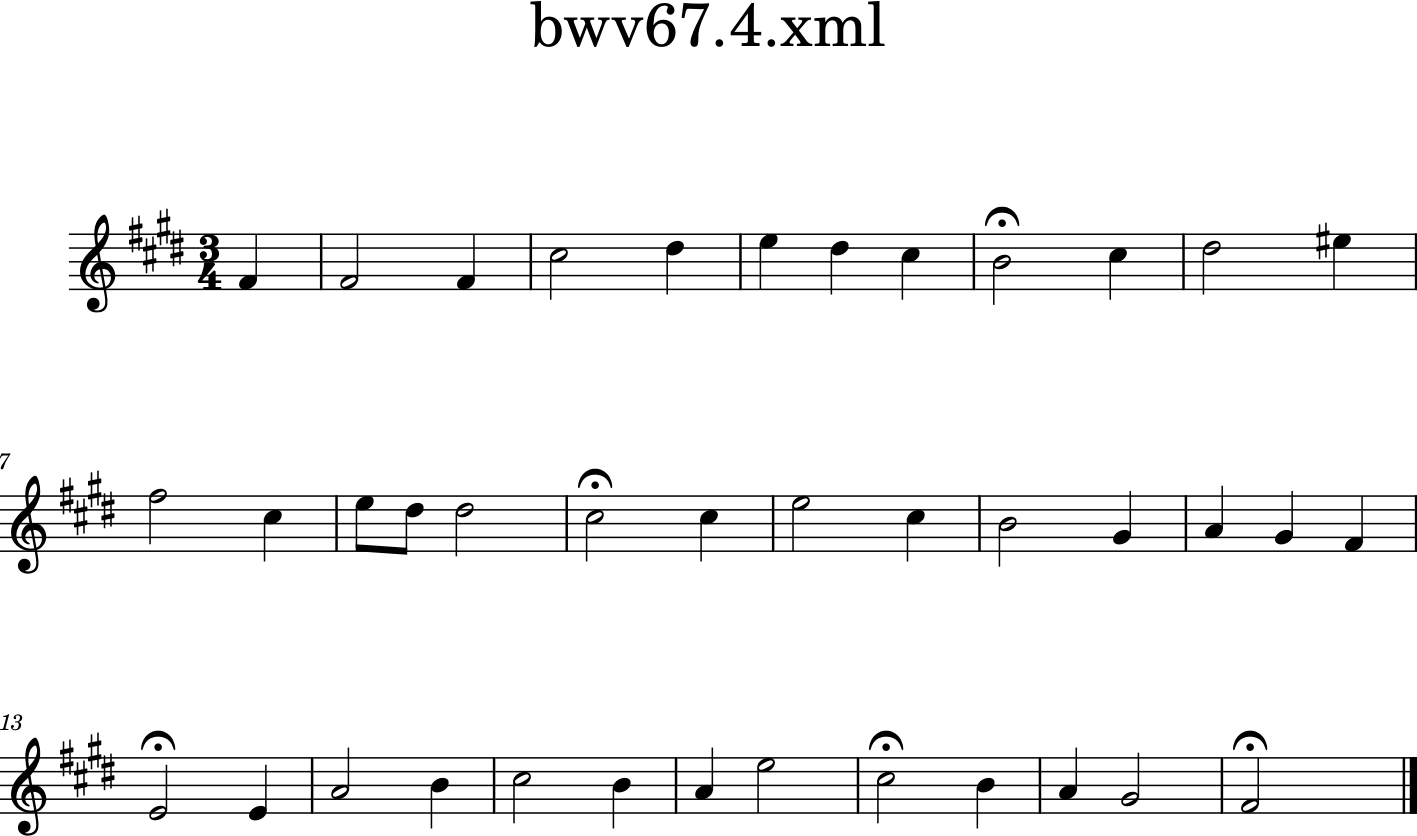

In [77]:
soprano_part.show()

In [99]:
intval = interval.Interval(emajor_pitches[0], pitch.Pitch('C4'))

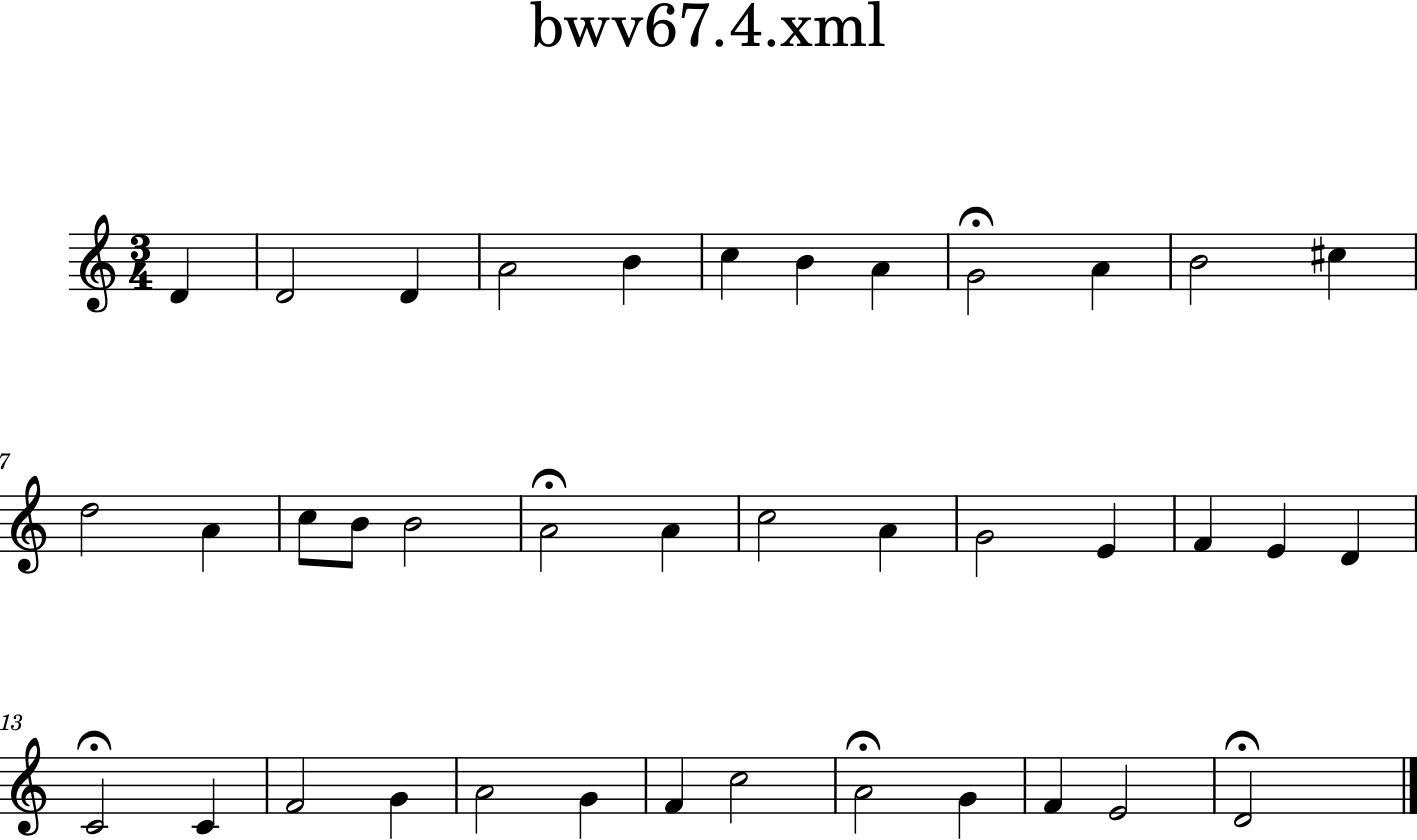

In [100]:
soprano_part.transpose(intval).show()

In [4]:
test_score = corpus.parse('Collector_Test.mxl')
parts = test_score.getElementsByClass(stream.Part)
soprano_part = parts[0]

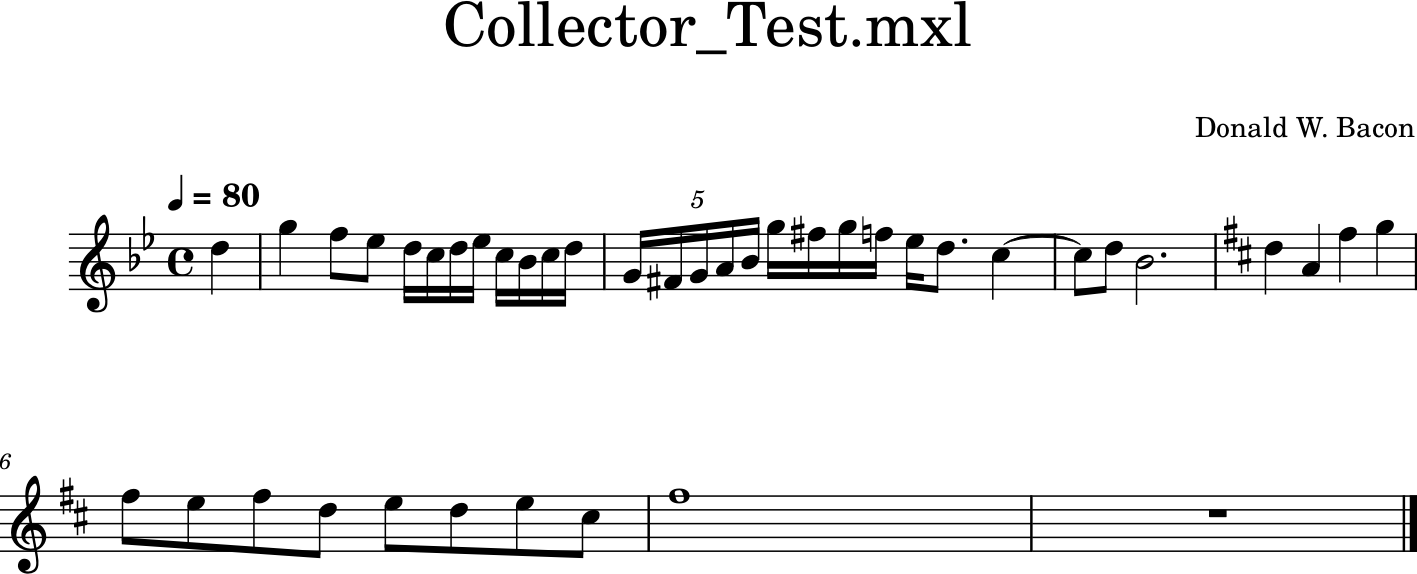

In [5]:
soprano_part.show()

In [6]:
measures = soprano_part.getElementsByClass(stream.Measure)
mnum = 0
for m in measures:
    keys = m.getElementsByClass([key.Key,key.KeySignature])
    for k in keys:
        print("{}\t{}".format(m.measureNumber,k))
        mnum=mnum+1


1	<music21.key.KeySignature of 2 flats>
5	<music21.key.KeySignature of 2 sharps>


In [7]:
keysigs, measurenums = MusicUtils.get_keySignatures(soprano_part)
print(keysigs)
print(measurenums)


[<music21.key.Key of B- major>, <music21.key.Key of D major>]
[1, 5]


In [8]:
keysigs[0].mode

'major'

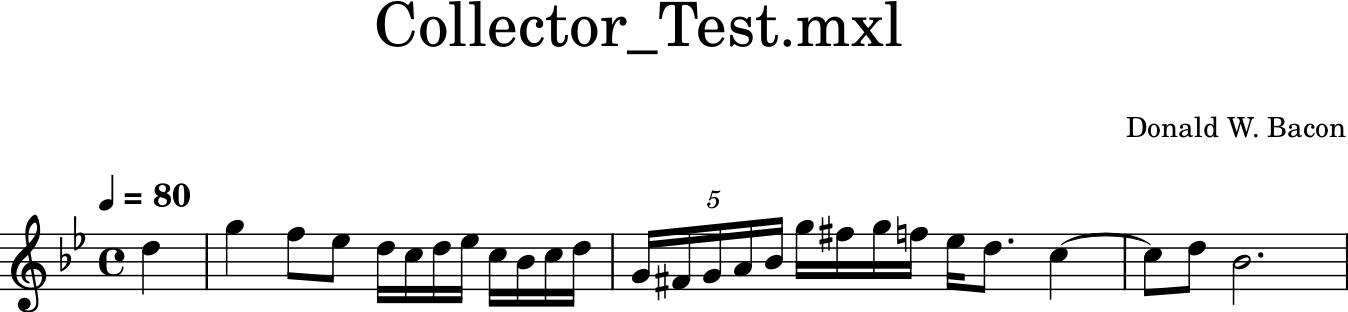

In [8]:
soprano_part.measures(1,4).show()

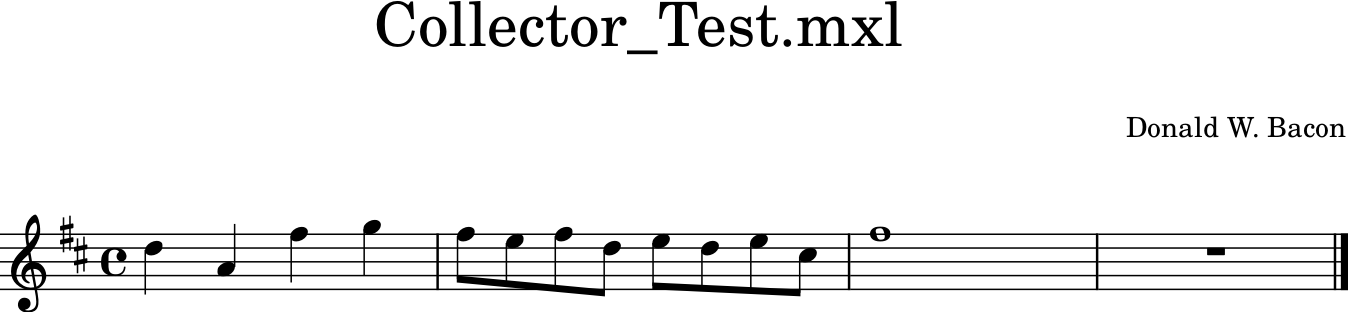

In [9]:
soprano_part.measures(5, len(soprano_part)).show()

In [10]:
keysigs[0].getPitches()

[<music21.pitch.Pitch B-4>,
 <music21.pitch.Pitch C5>,
 <music21.pitch.Pitch D5>,
 <music21.pitch.Pitch E-5>,
 <music21.pitch.Pitch F5>,
 <music21.pitch.Pitch G5>,
 <music21.pitch.Pitch A5>,
 <music21.pitch.Pitch B-5>]

In [11]:
keysigs[1].getPitches()

[<music21.pitch.Pitch D4>,
 <music21.pitch.Pitch E4>,
 <music21.pitch.Pitch F#4>,
 <music21.pitch.Pitch G4>,
 <music21.pitch.Pitch A4>,
 <music21.pitch.Pitch B4>,
 <music21.pitch.Pitch C#5>,
 <music21.pitch.Pitch D5>]

In [9]:
intval = []
for ks in keysigs:
    p1 = ks.getPitches()[0]
    p2 = note.Note(name='C', octave=p1.octave)
    print(p1.nameWithOctave,p2.nameWithOctave)
    intval.append(interval.Interval(noteStart = p1,noteEnd = p2))
for ival in intval:
    print(ival.simpleName)

B-4 C4
D4 C4
m7
M2


In [10]:
notes_df, score_partNames, score_partNumbers = MusicUtils.get_music21_objects_for_score(note.Note, test_score)

In [11]:
notes_df

,note,part_number,part_name,name,nameWithOctave,pitch,duration,pitchClass
0,<music21.note.Note D>,1,Soprano,D,D5,D5,<music21.duration.Duration 1.0>,2
1,<music21.note.Note G>,1,Soprano,G,G5,G5,<music21.duration.Duration 1.0>,7
2,<music21.note.Note F>,1,Soprano,F,F5,F5,<music21.duration.Duration 0.5>,5
3,<music21.note.Note E->,1,Soprano,E-,E-5,E-5,<music21.duration.Duration 0.5>,3
4,<music21.note.Note D>,1,Soprano,D,D5,D5,<music21.duration.Duration 0.25>,2
...,...,...,...,...,...,...,...,...
1,<music21.note.Note G>,4,Bass,G,G2,G2,<music21.duration.Duration 0.5>,7
2,<music21.note.Note B->,4,Bass,B-,B-2,B-2,<music21.duration.Duration 1.0>,10
3,<music21.note.Note G>,4,Bass,G,G2,G2,<music21.duration.Duration 1.0>,7
4,<music21.note.Note D>,4,Bass,D,D3,D3,<music21.duration.Duration 1.0>,2


In [20]:
next_note = notes_df.iloc[3]
print(next_note)
next_note.loc['nameWithOctave']

note                       <music21.note.Note E->
part_number                                     1
part_name                                 Soprano
name                                           E-
nameWithOctave                                E-5
pitch                                         E-5
duration          <music21.duration.Duration 0.5>
pitchClass                                      3
Name: 3, dtype: object


'E-5'

In [17]:
MusicUtils.get_transposition_interval(keysigs)

[<music21.interval.Interval m-7>, <music21.interval.Interval M-2>]

In [20]:
p1 = note.Note('C4')
p2 = note.Note('C4')
ival = interval.Interval(noteStart = p1,noteEnd = p2)
ival.semitones

0

In [20]:
pdict = MusicUtils.get_score_notes(test_score)
pdict['Soprano']

<music21.stream.iterator.StreamIterator for Part:Soprano_flat @:0>

### Test reading chain .csv

In [3]:
durations_df = pd.read_csv("/Compile/dwbzen/resources/music/bwv40_8_durationsChain.csv")
durations_df

,KEY,1.0,1.5,2.0,0.5
0,"[1.0, 1.0]",0.824,0.059,0.059,0.059
1,"[1.5, 0.5]",0.800,0.000,0.200,0.000
2,"[2.0, 1.0]",0.889,0.000,0.000,0.111
3,"[1.0, 1.5]",0.000,0.000,0.000,1.000
4,"[0.5, 2.0]",1.000,0.000,0.000,0.000
5,"[1.0, 2.0]",0.667,0.000,0.000,0.333
6,"[1.0, 0.5]",0.000,0.000,0.000,1.000
7,"[0.5, 1.0]",0.600,0.000,0.133,0.267
8,"[0.5, 0.5]",0.200,0.000,0.075,0.725
9,"[2.0, 0.5]",0.000,0.000,0.000,1.000


In [4]:
new_index = durations_df['KEY']
new_index.values

array(['[1.0, 1.0]', '[1.5, 0.5]', '[2.0, 1.0]', '[1.0, 1.5]',
       '[0.5, 2.0]', '[1.0, 2.0]', '[1.0, 0.5]', '[0.5, 1.0]',
       '[0.5, 0.5]', '[2.0, 0.5]'], dtype=object)

In [5]:
durations_df.index=new_index.values
durations_df.drop(['KEY'],axis=1,inplace=True)
durations_df

,1.0,1.5,2.0,0.5
"[1.0, 1.0]",0.824,0.059,0.059,0.059
"[1.5, 0.5]",0.800,0.000,0.200,0.000
"[2.0, 1.0]",0.889,0.000,0.000,0.111
"[1.0, 1.5]",0.000,0.000,0.000,1.000
"[0.5, 2.0]",1.000,0.000,0.000,0.000
"[1.0, 2.0]",0.667,0.000,0.000,0.333
"[1.0, 0.5]",0.000,0.000,0.000,1.000
"[0.5, 1.0]",0.600,0.000,0.133,0.267
"[0.5, 0.5]",0.200,0.000,0.075,0.725
"[2.0, 0.5]",0.000,0.000,0.000,1.000


In [7]:
mc_df = pd.read_csv("/Compile/dwbzen/resources/music/bwv40_8_intervalsChain.csv")
new_index = mc_df['KEY']
mc_df.index = new_index.values
mc_df.drop(['KEY'],axis=1,inplace=True)
mc_df

,-1,1,0,2,-3,-5,5,-4,-1.1,8,-2,100,4,-6,3,-7,12,7,-12
"[99, 0]",0.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.500000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
"[0, -1]",0.0,0.300000,0.400000,0.000000,0.000000,0.000000,0.0,0.3,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
"[-1, 1]",0.0,0.000000,0.444444,0.444444,0.000000,0.111111,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
"[1, 0]",0.0,0.000000,0.230769,0.076923,0.230769,0.000000,0.0,0.0,0.230769,0.0,0.000000,0.076923,0.076923,0.076923,0.0,0.0,0.0,0.0,0.0
"[0, 2]",0.0,0.333333,0.444444,0.000000,0.111111,0.000000,0.0,0.0,0.000000,0.0,0.111111,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"[0, 7]",0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
"[-2, -3]",0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
"[-2, 12]",0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
"[12, 0]",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [39]:
aScore = corpus.parse('bwv40.8')
int_df = MusicUtils.get_interval_stats(aScore)
int_df

,semitones,count
8,0,91
10,2,51
6,-2,51
9,1,39
7,-1,35
13,5,25
5,-3,19
1,-7,11
4,-4,10
12,4,5


In [55]:
parts = aScore.getElementsByClass(Part)
soprano_part = parts['Soprano']
print(len(soprano_part))

21


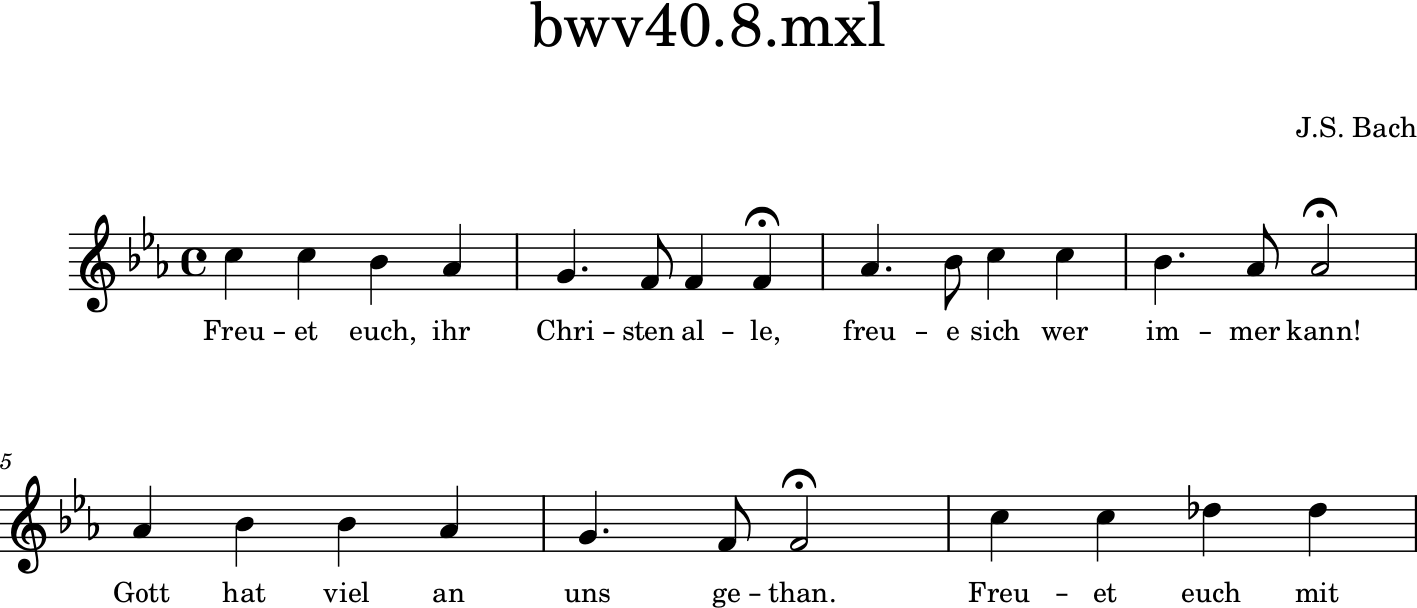

C5
C5
B-4
A-4
G4
F4
F4
F4
A-4
B-4
C5
C5
B-4
A-4
A-4
A-4
B-4
B-4
A-4
G4
F4
F4
C5
C5
D-5
D-5


In [61]:
sop_measures = soprano_part.measures(1, 7)
sop_measures.show()
for p in sop_measures.pitches:
    print(p)

In [13]:
df = pd.read_json("resources/music/common_scaleFormulas.json", orient='columns')
df

,scales
0,"{'name': 'Major', 'groups': ['major', 'diatoni..."
1,"{'name': 'Minor', 'alternateNames': ['Natural ..."
2,"{'name': 'Melodic minor ascending', 'groups': ..."
3,"{'name': 'Harmonic minor', 'groups': ['minor',..."
4,"{'name': 'Chromatic', 'groups': ['chromatic'],..."
...,...
602,"{'name': 'Whole-Tone Tetramirror', 'groups': [..."
603,"{'name': 'Whole-Tone, Anhemitonic Hexatonic (a..."
604,"{'name': 'Youlan (China) 2# 4# 7b', 'groups': ..."
605,{'name': 'Youlan -China All Flat - 2b 4b 5b 7b...


In [2]:
df = pd.read_json("resources/music/commonScaleFormulas.json", orient='records').transpose()
df

,groups,formula,size,alternateNames
(as 7/367/1 in 12edo),[untitled],"[1, 3, 3, 2, 3]",5,NaN
Adonai Malakh (Israel) 2b 1#,[adonai],"[1, 1, 1, 2, 2, 2, 1, 2]",8,NaN
Adonai Malakh (Israel) 3b's,[adonai],"[1, 1, 1, 2, 2, 2, 1, 2]",8,NaN
Aeolian 2# 4# #5,[aeolian],"[3, 1, 2, 2, 1, 2, 1]",7,NaN
Aeolian Flat 3b 5b 6b 8b,[aeolian],"[3, 1, 2, 2, 1, 2, 1]",7,NaN
...,...,...,...,...
untitled Nonatonic 2,[untitled],"[1, 2, 1, 1, 1, 1, 2, 1, 2]",9,NaN
untitled Nonatonic 2 - 6b's,[untitled],"[1, 2, 1, 1, 1, 1, 2, 1, 2]",9,NaN
untitled Nonatonic 2 - 4#'s,[untitled],"[1, 2, 1, 1, 1, 1, 2, 1, 2]",9,NaN
whole tone #'s in 12edo),[whole],"[2, 2, 2, 2, 2, 2]",6,[Raga Gopriya (India) Anhemitonic Hexatonic]


In [3]:
formula = df.loc['Major']['formula']
formula

[2, 2, 1, 2, 2, 2, 1]

In [4]:
s = stream.Stream()
s.append(key.Key('C'))
n = note.Note('C4')
s.append(n)
for i in range(len(formula)):
    n = n.transpose(formula[i], inPlace=False)
    s.append(n)
[x.nameWithOctave for x in s.notes]

['C4', 'D4', 'E4', 'F4', 'G4', 'A4', 'B4', 'C5']

In [12]:
n.pitch.name

'C'